# Generate figures after Fatiando website analytics data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

## Load custom matplotlib configuration

In [2]:
plt.style.use("matplotlib.rc")

## Define paths to analytics files and to output figures directory

In [3]:
data_dir = Path("data")
active_users_file = data_dir / "fatiando-active-users.xlsx"
users_locations_file = data_dir / "fatiando-users-location.xlsx"

In [4]:
figs_dir = Path("..") / "thesis" / "figs" / "fatiando"

## Active users

In [5]:
active_users = pd.read_excel(active_users_file, sheet_name=1, index_col=0).drop(index="NaT")
active_users

/home/santi/.miniforge3/envs/phd-thesis/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Usuarios activos en un día
Índice de día,
2017-04-01,18
2017-04-02,17
2017-04-03,28
2017-04-04,22
2017-04-05,50
...,...
2021-09-25,152
2021-09-26,76
2021-09-27,281


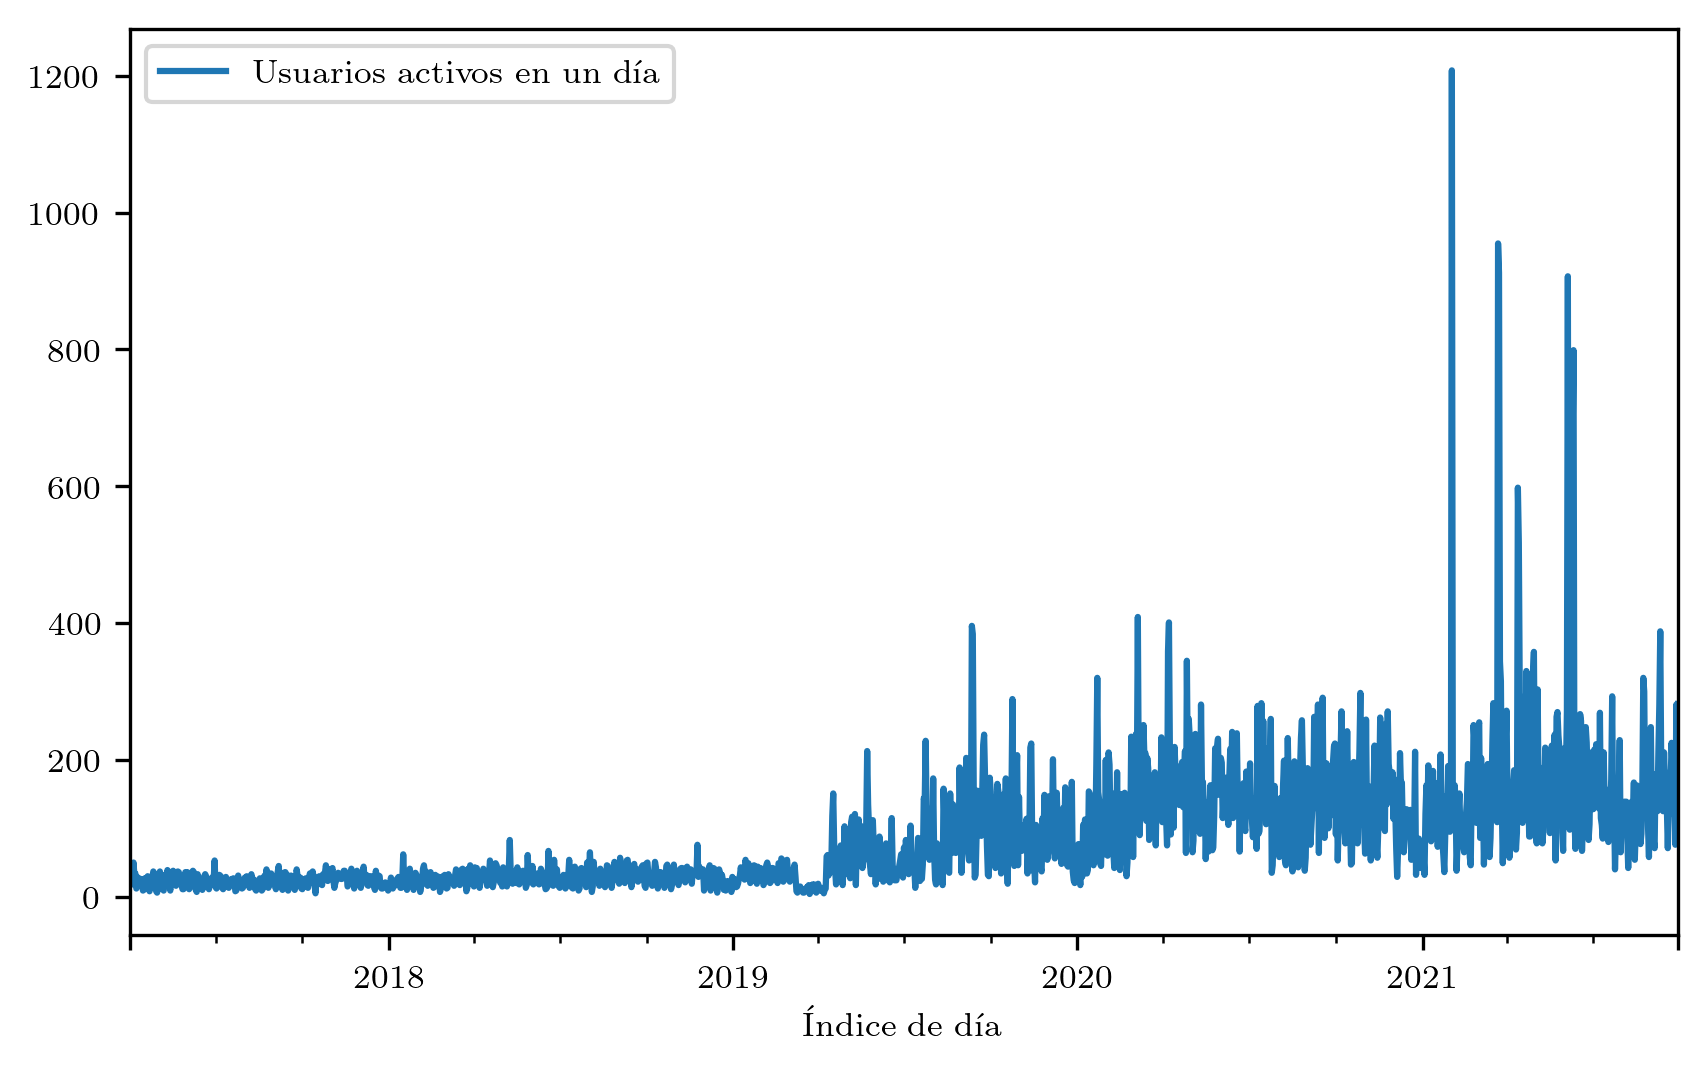

In [6]:
fig, ax = plt.subplots(figsize=(6.66, 4))
active_users.plot(ax=ax)
plt.show()

In [7]:
# Check if every day since start and end date is present in the dataframe
time_steps = active_users.index[1:] - active_users.index[:-1]
assert (time_steps == time_steps[0]).all()

In [8]:
window_size = 28
active_users_monthly = active_users.rolling(window=window_size).sum()
active_users_monthly = active_users_monthly.rename(columns={"Usuarios activos en un día": f"Usuarios activos en {window_size} días"})

In [9]:
active_users_monthly

,Usuarios activos en 28 días
Índice de día,
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,NaN
2017-04-04,NaN
2017-04-05,NaN
...,...
2021-09-25,4697.0
2021-09-26,4715.0
2021-09-27,4820.0


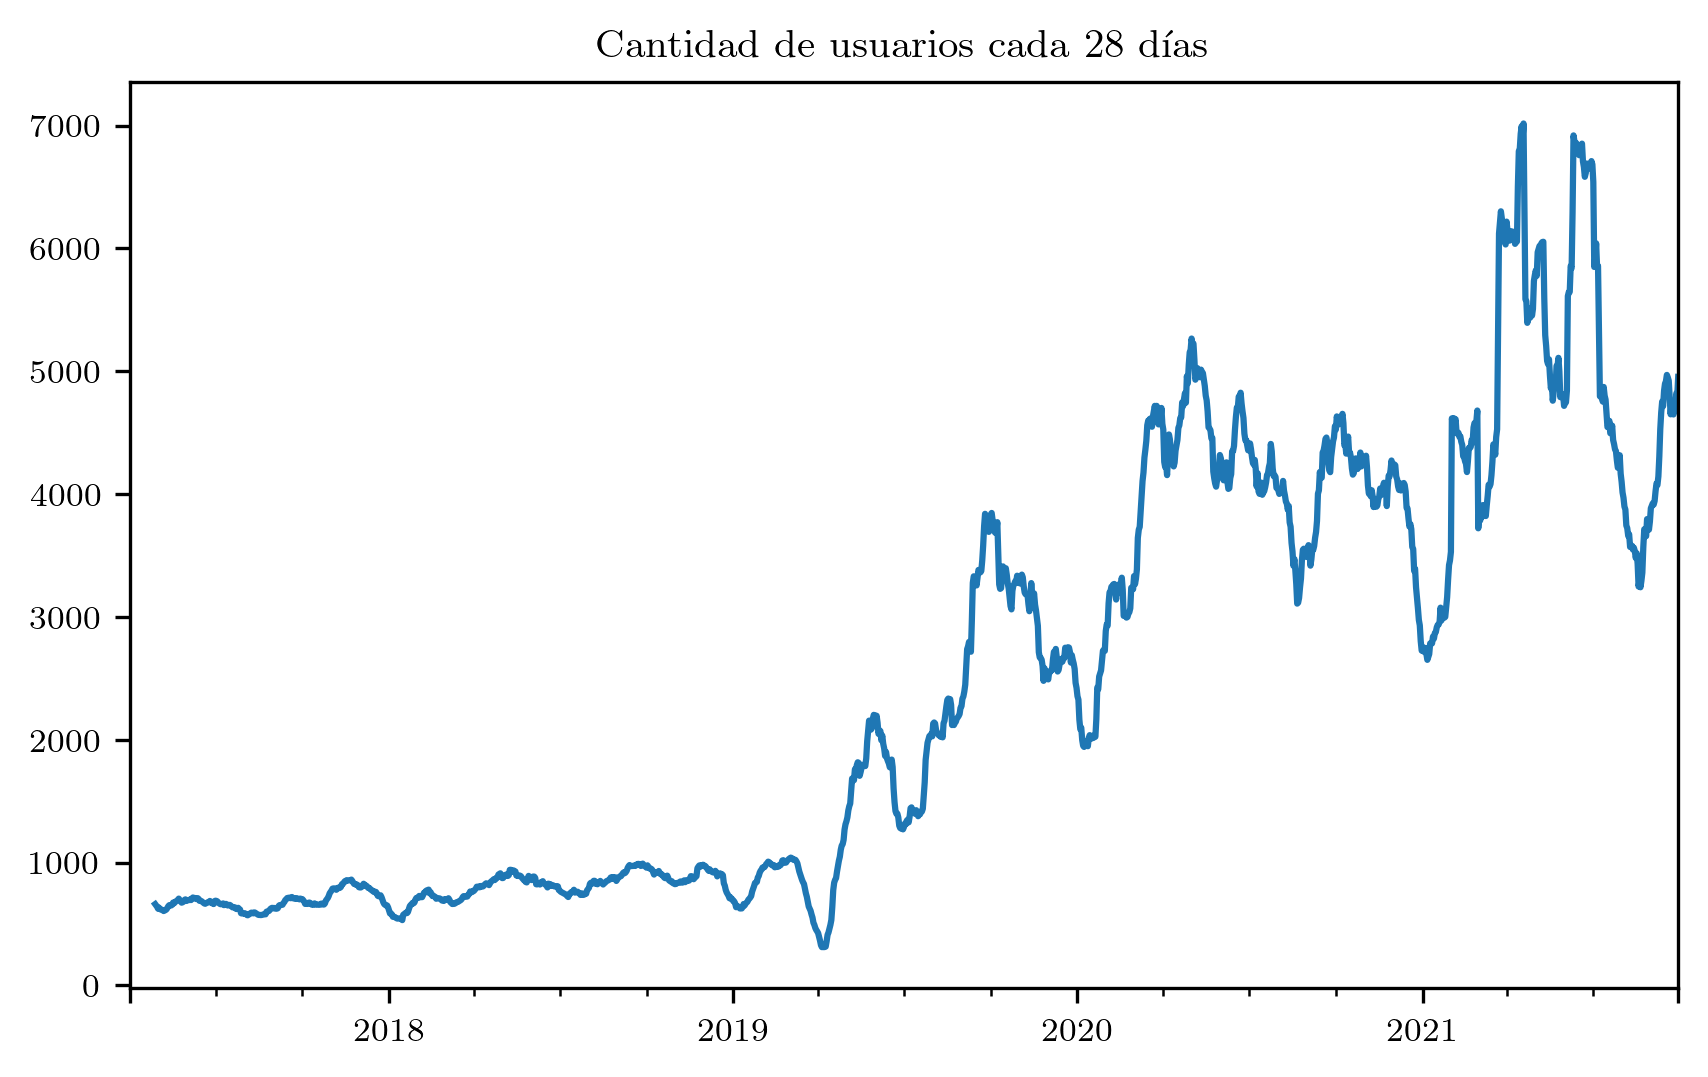

In [10]:
fig, ax = plt.subplots(figsize=(6.66, 4))
active_users_monthly.plot(ax=ax, legend=False)
ax.set_xlabel("")
plt.title("Cantidad de usuarios cada 28 días")
plt.savefig(figs_dir / "users_history.pdf")
plt.show()

## Read geographic location of users

In [11]:
users_locations = pd.read_excel(users_locations_file, sheet_name=1, index_col=0).drop(np.nan).drop("(not set)")
users_locations = users_locations[["Usuarios"]]
users_locations

/home/santi/.miniforge3/envs/phd-thesis/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Usuarios
País,
United States,20316
China,14498
Brazil,14093
Indonesia,8378
United Kingdom,6956
...,...
Mauritius,1
Maldives,1
Palestine,1


In [12]:
# Rename United States for United States of America
users_locations = users_locations.rename(index={"United States": "United States of America"})
users_locations

,Usuarios
País,
United States of America,20316
China,14498
Brazil,14093
Indonesia,8378
United Kingdom,6956
...,...
Mauritius,1
Maldives,1
Palestine,1


In [13]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [14]:
table = world.merge(users_locations, how="right", left_on=['name'], right_on=['País'])

In [15]:
table

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Usuarios
0,3.266258e+08,North America,United States of America,USA,18560000.00,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",20316
1,1.379303e+09,Asia,China,CHN,21140000.00,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",14498
2,2.073534e+08,South America,Brazil,BRA,3081000.00,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2...",14093
3,2.605807e+08,Asia,Indonesia,IDN,3028000.00,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...",8378
4,6.476945e+07,Europe,United Kingdom,GBR,2788000.00,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",6956
...,...,...,...,...,...,...,...
172,NaN,NaN,NaN,NaN,NaN,None,1
173,NaN,NaN,NaN,NaN,NaN,None,1
174,4.543126e+06,Asia,Palestine,PSE,21220.77,"POLYGON ((35.39756 31.48909, 34.92741 31.35344...",1
175,7.965055e+06,Africa,Togo,TGO,11610.00,"POLYGON ((0.89956 10.99734, 0.77234 10.47081, ...",1


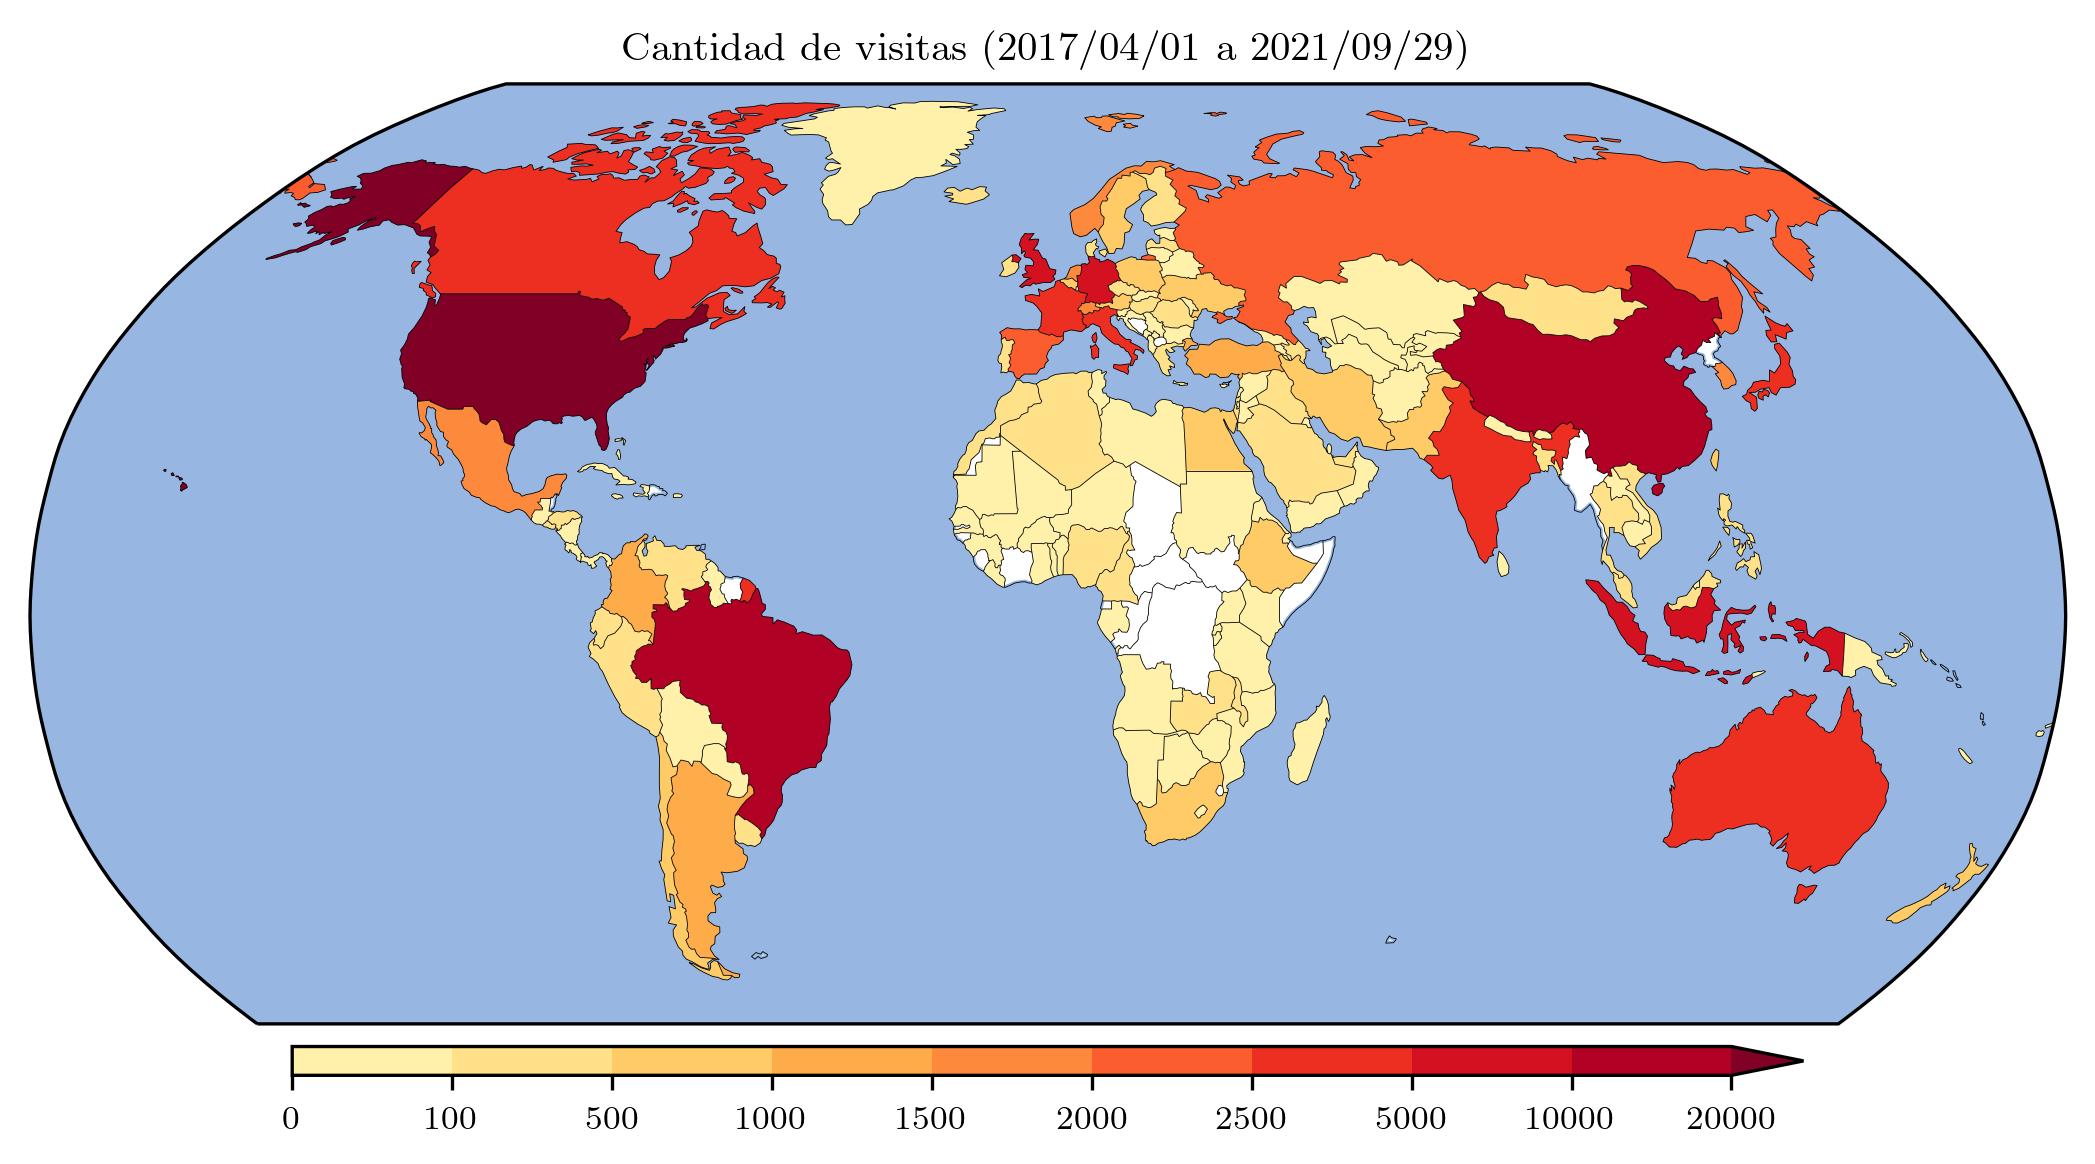

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

# Build custom colormap
vmax = table.Usuarios.max()
boundaries = [0, 100, 500, 1000, 1500, 2000, 2500, 5000, 10000, 20000, vmax]
orig_cmap = plt.cm.YlOrRd
colours = orig_cmap(np.linspace(0.1, 1, len(boundaries)))
cmap = colors.LinearSegmentedColormap.from_list("mycmap", colours)
norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

table.plot(
    column="Usuarios",
    cmap=cmap,
    norm=norm,
    linewidth=0,
    edgecolor="k",
    ax=ax,
    transform=ccrs.PlateCarree(),
)
fig.colorbar(
    sm,
    boundaries=boundaries,
    extend="max",
    orientation="horizontal",
    pad=0.02,
    aspect=50,
    shrink=0.65,
)
ax.set_title("Cantidad de visitas (2017/04/01 a 2021/09/29)")
ax.tick_params(
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
plt.savefig(figs_dir / "users_map.pdf")
plt.show()